https://pytorch.org/docs/stable/library.html

In [1]:
from typing import Callable
from cgtnnlib.AugmentedReLUNetwork import AugmentedReLUNetwork
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NetworkLike import NetworkLike
from cgtnnlib.PlotModel import PlotModel
from cgtnnlib.Report import Report, eval_report_key
from cgtnnlib.TrainingParameters import TrainingParameters
from cgtnnlib.common import DATASETS, LEARNING_RATE, eval_inner
from cgtnnlib.training import train_model


REPORT = Report(dir="workbench/")
DATASET = DATASETS[2]
P = 0.5


MODEL_CONSTRUCTOR: Callable[[int, int, float], NetworkLike] = AugmentedReLUNetwork

DATASET

Dataset(name='StudentPerformanceFactors.csv', learning_task=LearningTask(name='regression', criterion=MSELoss(), dtype=torch.float32), number=3, classes_count=1, data=DatasetData(train_dataset=<torch.utils.data.dataset.TensorDataset object at 0x18afa6270>, test_dataset=<torch.utils.data.dataset.TensorDataset object at 0x18b20b230>, train_loader=<torch.utils.data.dataloader.DataLoader object at 0x18af7ca40>, test_loader=<torch.utils.data.dataloader.DataLoader object at 0x18af7d640>))

In [2]:
import torch.optim as optim

from cgtnnlib.training import save_model_to_path


for iteration in range(1, 11):
    experiment_params = ExperimentParameters(
        iteration=iteration,
        p=P
    )

    # Training

    training_params = TrainingParameters(
        dataset=DATASET,
        learning_task=DATASET.learning_task,
        experiment_params=experiment_params,
    )
    model_path = f"workbench/WorkbenchModel{iteration}.pth"
    model = MODEL_CONSTRUCTOR(
        inputs_count=DATASET.features_count,
        outputs_count=DATASET.classes_count,
        p=experiment_params.p,
    )

    running_losses = train_model(
        model=model,
        dataset=DATASET,
        epochs=10,
        experiment_params=experiment_params,
        criterion=DATASET.learning_task.criterion,
        optimizer=optim.Adam(
            model.parameters(),
            lr=LEARNING_RATE,
        )
    )

    save_model_to_path(model, model_path)
    REPORT.record_running_losses(running_losses,
                                 model,
                                 training_params,
                                 experiment_params)

    # Evaluation

    eval_params = EvaluationParameters(
        dataset=DATASET,
        model_path=model_path,
        experiment_parameters=experiment_params,
        report_key=eval_report_key(
            model_name=MODEL_CONSTRUCTOR.__name__,
            dataset_number=DATASET.number,
            p=P,
            iteration=iteration,
        )
    )

    eval_inner(
        eval_params=eval_params,
        experiment_params=experiment_params,
        constructor=MODEL_CONSTRUCTOR
    )

REPORT.see()
REPORT.save()

Evaluating model at workbench/WorkbenchModel10.pth...
Evaluation of regression (head):
   noise_factor        r2        mse
0          0.00 -0.082447  16.663021
1          0.04 -0.085077  16.703510
2          0.08 -0.085323  16.707289
3          0.12 -0.090037  16.779865
4          0.16 -0.100004  16.933294
Report workbench/report.json
started: '2024-12-04T13:10:57.663786'
loss_AugmentedReLUNetwork_3_p0.5_N1: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N1: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N2: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N2: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N3: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N3: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N4: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N4: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N5: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N5: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N6: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N6: dict

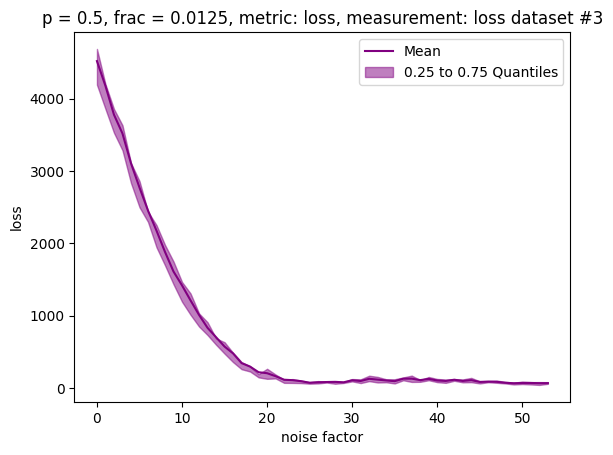

In [3]:
import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt, search_curve_for_report

METRIC='loss'
MEASUREMENT='loss'
FRAC=0.0125

CURVE = search_curve_for_report(
    report_path=REPORT.path,
    model=PlotModel(
        measurement=MEASUREMENT,
        dataset_number=DATASET.number,
        metric=METRIC,
        p=P,
        frac=FRAC,
    )
)

plot_deviant_curves_on_ax_or_plt(
    ax_or_plt=plt,
    models=[{
        'curve': CURVE,
        'color': 'purple',
        'label': 'Mean',
        'quantiles_color': 'purple',
        'quantiles_label': '0.25 to 0.75 Quantiles',
    }],
    title=f'p = {P}, frac = {FRAC}, metric: {METRIC}, measurement: {MEASUREMENT} dataset #{DATASET.number}',
    xlabel='noise factor',
    ylabel=METRIC,
)